In [1]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
from torch import nn
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import glob

import matplotlib.pyplot as plt
import numpy as np

import tqdm

import skimage

from torch.utils.data import DataLoader, Dataset

import os
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
root = Path('../').resolve()
os.chdir(root)

CONCH

In [ ]:
class CONCHModelForFinetuning(nn.Module):
    def __init__(self, num_classes=2, config={'hidden_size': 512}): # change number of classes for each dataset(8 for breast, 2 for breast)
        super().__init__()
        self.config = config
        self.model = self.make_conch()
        # self.fc = nn.Linear(self.config['hidden_size'], num_classes) # full finetuning?

        # linear probing
        # Freeze all parameters in the backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Only this linear layer will be trained
        self.fc = nn.Linear(self.config['hidden_size'], num_classes)

    def make_conch(self):
        # Load the model from "create_model_from_pretrained"
        model_cfg = 'conch_ViT-B-16'
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
        checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' # load in checkpoint here
        # checkpoint_path = r'C:\Users\Vivian\Documents\CONCH\_finetune_weights\Fold2_F_PT_model.pth' # loading breakhis finetuned model
        model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
        
        return model
        
    def forward(self, x):
        out, h = self.model.visual(x)
        return self.fc(out)

In [ ]:
model = CONCHModelForFinetuning().to('cuda')

load breakhis (PT + FA) checkpoint

In [ ]:
class CONCHModelForFinetuning(nn.Module):
    def __init__(self, num_classes=2, config={'hidden_size': 512}, checkpoint_path=None):
        super().__init__()
        self.config = config
        self.model = self.make_conch()
        self.fc = nn.Linear(self.config['hidden_size'], num_classes)

        if checkpoint_path is not None:
            print(f"Loading fine-tuned weights from: {checkpoint_path}")
            self.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))

    def make_conch(self):
        # Load the base pretrained model
        model_cfg = 'conch_ViT-B-16'
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        base_checkpoint = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin'
        model, _ = create_model_from_pretrained(model_cfg, base_checkpoint, device=device)
        return model

    def forward(self, x):
        out, h = self.model.visual(x)
        return self.fc(out)


In [ ]:
checkpoint_path = r'C:\Users\Vivian\Documents\CONCH\_finetune_weights\Fold2_F_PT_model.pth'
model = CONCHModelForFinetuning(num_classes=2, checkpoint_path=checkpoint_path).to('cuda')

UNI 2

In [ ]:


class UNI2ModelForFinetuning(nn.Module):
    def __init__(self, num_classes=2): # change number of classes for each dataset
        super().__init__()
        # self.config = config
        self.model = self.make_uni2()
        # self.fc = nn.Linear(1536, num_classes)  # Match Vision Transformer output # full finetuning

        # Freeze all backbone parameters for linear probing
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a small trainable classification head
        self.fc = nn.Linear(1536, num_classes)  # Match Vision Transformer output

    def make_uni2(self):
        # # Load the model from "create_model_from_pretrained"
        # model_cfg = 'conch_ViT-B-16'
        # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # # checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
        # checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' # load in checkpoint here
        # model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
        
        # return model

        # local_dir = 'assets\\ckpts\\uni2-h'
        local_dir = 'C:\\Users\\Vivian\\Documents\\UNI2\\UNI\\assets\\ckpts\\uni2-h' 
        os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
        # hf_hub_download("MahmoodLab/UNI2-h", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
       
        timm_kwargs = {
        'model_name': 'vit_giant_patch14_224',
        'img_size': 224, 
        'patch_size': 14, 
        'depth': 24,
        'num_heads': 24,
        'init_values': 1e-5, 
        'embed_dim': 1536,
        'mlp_ratio': 2.66667*2,
        'num_classes': 0, 
        'no_embed_class': True,
        'mlp_layer': timm.layers.SwiGLUPacked, 
        'act_layer': torch.nn.SiLU, 
        'reg_tokens': 8, 
        'dynamic_img_size': True
        }
        model = timm.create_model(**timm_kwargs)
        model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
        # transform = transforms.Compose(
        # [
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # ]
        # )

        return model 
        
    def forward(self, x):
        out = self.model(x)
        # out, h = self.model.visual(x)
        return self.fc(out)

In [ ]:
model = UNI2ModelForFinetuning().to('cuda')

UNI

In [ ]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download


class UNIModelForFinetuning(nn.Module):
    def __init__(self, num_classes=2,checkpoint_path=None): # change number of classes accordingly 
        ## ************ change for UNI ************
        super().__init__()
        # self.config = config
        self.model = self.make_uni()
        # self.fc = nn.Linear(self.config['hidden_size'], num_classes) # keep commented
        # self.fc = nn.Linear(1024, num_classes)  # Match Vision Transformer output # full finetuning

        #***** Freeze all backbone parameters - linear probing *****
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a trainable classification head
        self.fc = nn.Linear(1024, num_classes)

        # ----- Load checkpoint if needed -----
        if checkpoint_path:
            print(f"Loading checkpoint from: {checkpoint_path}")
            self.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))
    
    def make_uni(self):
        # login()  # login with your User Access Token, found at https://huggingface.co/settings/tokens

        local_dir = r"C:\Users\Vivian\Documents\CONCH\checkpoints\uni" # load in UNI model
        os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
        
        # hf_hub_download("MahmoodLab/UNI", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
        model = timm.create_model(
            "vit_large_patch16_224", img_size=224, patch_size=16, init_values=1e-5, num_classes=0, dynamic_img_size=True
        )
        model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
        
        # transform = transforms.Compose(
        #     [
        #         transforms.Resize(224),
        #         transforms.ToTensor(),
        #         transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #     ]
        # )
        # model.eval()
        return model 
    
    def forward(self, x):
        out = self.model(x)
        # out, h = self.model.visual(x)
        return self.fc(out)

In [ ]:
model = UNIModelForFinetuning().to('cuda')

In [ ]:
# Loading a checkpoint
model = UNIModelForFinetuning(num_classes=2, checkpoint_path=r"C:\Users\Vivian\Documents\CONCH\_finetune_weights_UNI\linprob_ann_CL_uni.pth").to('cuda')

ResNet

In [2]:
import torchvision.models as models
import torch.nn as nn

# resnet = models.resnet18(pretrained=True) # resnet18
resnet = models.resnet50(pretrained=True) # resnet50
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  # 2 output classes for CrossEntropyLoss


c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model = resnet.to('cuda')

<!-- Making metadata -->

In [ ]:
# saves metadata to csv for each fold and mode - use this 
# need to make metadata for new datasets
def make_metadata(fold):
    metadata = pd.DataFrame()
    for mode in ['train', 'test']:
        pathname = f'/Users/Vivian/Documents/CONCH/Folds/Fold {fold}/{mode}/'
        images = os.listdir(pathname)
        for image in images:
            if not image.startswith('SOB'):
                continue
            label = image.split('-')[0].replace('SOB_', '')
            class_name, subclass_name = label.split('_')
            #metadata = metadata.append({'image': pathname+image, 'fold': fold, 'mode': mode, 'class': class_name, 'subclass': subclass_name}, ignore_index=True)
            metadata = pd.concat([metadata, pd.DataFrame({'image': pathname+image, 'fold': fold, 'mode': mode, 'class': class_name, 'subclass': subclass_name}, index=[0])], ignore_index=True)
        metadata.to_csv(f'/Users/Vivian/Documents/CONCH/Folds/Fold {fold}/{mode}/metadata.csv', index=False)
    return metadata

In [ ]:
# making metadata for our private dataset
import os
import pandas as pd

def make_metadata():
    metadata = pd.DataFrame()
    
    # # Define paths
    # base_path = "patches"  # Root where patches are stored
    # metadata_dir = "metadata"  # Directory containing train/test CSVs
    # output_dir = "metadata/fine_tuning"  # Where metadata CSVs will be saved
    # os.makedirs(output_dir, exist_ok=True)

    # ***********Define paths for only test set
    base_path = "patches_annotated"  # Root where patches are stored
    metadata_dir = "metadata"  # Directory containing train/test CSVs
    output_dir = "metadata/fine_tuning"  # Where metadata CSVs will be saved
    os.makedirs(output_dir, exist_ok=True)
    # ************

    # Load train/test slide selections
    # train_slides = pd.read_csv(os.path.join(metadata_dir, "train_patient_split.csv"))
    test_slides = pd.read_csv(os.path.join(metadata_dir, "test_ann_series8.csv"))

    # train_slides = pd.read_csv(os.path.join(metadata_dir, "train_all_slides.csv"))
    # test_slides = pd.read_csv(os.path.join(metadata_dir, "test_all_slides.csv"))


    # Process both train and test sets
    # for mode, slides_df in zip(["train", "test"], [train_slides, test_slides]):
    for mode, slides_df in zip(["test"], [test_slides]): # only creating test set

        entries = []
        
        for _, row in slides_df.iterrows():
            slide_name = row["Filename"]
            class_name = row["Class"]
            magnification = f"{row['Magnification']}x"

            # Define the path where patches are stored for this slide
            slide_patch_dir = os.path.join(base_path, magnification, class_name, slide_name)

            # Ensure slide directory exists and has patches
            if not os.path.exists(slide_patch_dir) or len(os.listdir(slide_patch_dir)) == 0:
                print(f"Skipping {slide_name}: No patches found.")
                continue
            
            # Add all patches in the slide directory to the metadata
            for patch_file in os.listdir(slide_patch_dir):
                if patch_file.endswith(".npy"):  # Ensure we're only adding valid patch files
                    patch_path = os.path.join(slide_patch_dir, patch_file)
                    entries.append({
                        "image": patch_path,
                        "fold": 1,  # Since you're using only one fold
                        "mode": mode,
                        "class": class_name,
                        "magnification": magnification
                    })

        # Convert list to DataFrame
        mode_metadata = pd.DataFrame(entries)

        # output_csv = 

        # Save metadata CSV for the mode
        mode_metadata.to_csv(os.path.join(output_dir, f"{mode}_ann_series8_2.csv"), index=False) # manually change metadata file name here

        print(f"Saved {mode}_ann_series8_2.csv with {len(mode_metadata)} entries.")

    return metadata

In [4]:
# making metadata for our private dataset - train, val, test
import os
import pandas as pd

def make_metadata():
    # === CONFIGURATION ===
    annotated_base_path = r"C:\Users\Vivian\Documents\CONCH\patches_tiled\patches_10x"
    # fallback_base_path = "patches"
    metadata_dir = "metadata/patient_split_annotate/slide_csv"
    output_dir = "metadata/patient_split_annotate/patch_csv_10x"
    os.makedirs(output_dir, exist_ok=True)

    # Define your CSVs and the filenames for outputs
    slide_sets = {
        "train": {
            "input_csv": os.path.join(metadata_dir, "train_split.csv"),
            "output_csv": "train_patches.csv"
        },
        "val": {
            "input_csv": os.path.join(metadata_dir, "val_split.csv"),
            "output_csv": "val_patches.csv"
        },
        "test": {
            "input_csv": os.path.join(metadata_dir, "test_split.csv"),
            "output_csv": "test_patches.csv"
        }
    }

    # === PROCESS EACH SET ===
    for mode, paths in slide_sets.items():
        slides_df = pd.read_csv(paths["input_csv"])
        entries = []

        for _, row in slides_df.iterrows():
            slide_name = row["Filename"]
            class_name = row["Class"]
            magnification = f"{row['Magnification']}x"

            # Try annotated path first
            slide_patch_dir = os.path.join(annotated_base_path, magnification, class_name, slide_name)
            if not os.path.exists(slide_patch_dir) or len(os.listdir(slide_patch_dir)) == 0:
                print(f"[{mode}] Skipping {slide_name}: No patches found in annotated path.")
                continue

            # # Fallback to regular patches if needed
            # if not os.path.exists(slide_patch_dir) or len(os.listdir(slide_patch_dir)) == 0:
            #     slide_patch_dir = os.path.join(fallback_base_path, magnification, class_name, slide_name)
            #     if not os.path.exists(slide_patch_dir) or len(os.listdir(slide_patch_dir)) == 0:
            #         print(f"[{mode}] Skipping {slide_name}: No patches found in either location.")
            #         continue

            # Collect patch metadata
            for patch_file in os.listdir(slide_patch_dir):
                if patch_file.endswith(".npy"):
                    patch_path = os.path.join(slide_patch_dir, patch_file)
                    entries.append({
                        "image": patch_path,
                        "fold": 1,
                        "mode": mode,
                        "class": class_name,
                        "magnification": magnification
                    })

        # Save metadata to CSV
        mode_metadata = pd.DataFrame(entries)
        output_csv_path = os.path.join(output_dir, paths["output_csv"])
        mode_metadata.to_csv(output_csv_path, index=False)
        print(f"[{mode}] Saved {paths['output_csv']} with {len(mode_metadata)} entries.")


In [5]:
make_metadata() 

[train] Saved train_patches.csv with 1044596 entries.
[val] Saved val_patches.csv with 289282 entries.
[test] Saved test_patches.csv with 203137 entries.


In [ ]:
# Custom Dataset class
class HistopathologyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {
            'B_A': 0,
            'B_F': 1,
            'B_PT': 2,
            'B_TA': 3,
            'M_DC': 4,
            'M_LC': 5,
            'M_MC': 6,
            'M_PC': 7
        }  # Example mapping of subclasses to numerical labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image']
        class_name = self.data.iloc[idx]['class']
        subclass_name = self.data.iloc[idx]['subclass']
        label = self.label_map[class_name + '_' + subclass_name]
        image = plt.imread(img_path)
        image = skimage.transform.resize(image, (224, 224))
        image = image.transpose((2, 0, 1))
        if self.transform:
            image = self.transform(image)
        return image, label



In [ ]:
# using breakhis dataset but only with 2 classes FA and PT 

from torch.utils.data import Dataset
import pandas as pd
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt

class HistopathologyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {
            'B_F': 0,   # Fibroadenoma → Class 0
            'B_PT': 1   # Phyllodes Tumor → Class 1
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image']
        class_name = self.data.iloc[idx]['class']
        subclass_name = self.data.iloc[idx]['subclass']

        # Map "B_F" -> 0, "B_PT" -> 1
        label = self.label_map[class_name + '_' + subclass_name]

        # Load and preprocess image
        image = plt.imread(img_path)
        image = skimage.transform.resize(image, (224, 224))
        image = image.transpose((2, 0, 1))  # Convert to C x H x W for PyTorch
        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
# updated dataset class for our private dataset with numpy files

import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class HistopathologyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Custom PyTorch Dataset for loading histopathology patches from .npy files.
        
        Args:
            csv_file (str): Path to the dataset metadata CSV file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Mapping FA -> 0, PT -> 1
        self.label_map = {'FA': 0, 'PT': 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image patch
        img_path = self.data.iloc[idx]['image']
        image = np.load(img_path)  # Load .npy file (already in NumPy format)

        # Ensure image is in (C, H, W) format for PyTorch
        if image.shape[-1] == 3:  # Check if image is in (H, W, C) format
            image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)

        # Resize to 224x224 if needed
        if image.shape[1] != 224 or image.shape[2] != 224:
            import skimage.transform
            image = skimage.transform.resize(image, (3, 224, 224), anti_aliasing=True)
        
        # Normalize pixel values
        image = torch.tensor(image, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get label
        class_name = self.data.iloc[idx]['class']
        label = self.label_map[class_name]  # Convert class name to label

        return image, label, img_path
        # return image, label


right now, we are only using the first fold?

In [ ]:
# train_data = HistopathologyDataset('/Users/Vivian/Documents/CONCH/Folds/Fold 1/train/metadata.csv')
# test_data = HistopathologyDataset('/Users/Vivian/Documents/CONCH/Folds/Fold 1/test/metadata.csv')

# early results --> pick one fold 
# pick a fold to train and test

train_data = HistopathologyDataset('/Users/Vivian/Documents/CONCH/Folds/Fold 2/train/metadata.csv')
test_data = HistopathologyDataset('/Users/Vivian/Documents/CONCH/Folds/Fold 2/test/metadata.csv')

In [ ]:
# make a dataloder for me please 
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

instantiating train and test set for private data

In [5]:
# # Example usage
# subset of slides
# train_dataset = HistopathologyDataset("metadata/fine_tuning/train_metadata.csv")
# test_dataset = HistopathologyDataset("metadata/fine_tuning/test_metadata.csv")

# testing with all slides successfully tiled
# train_dataset = HistopathologyDataset("metadata\\fine_tuning\\train_patient_split_metadata.csv")
# test_dataset = HistopathologyDataset("metadata\\fine_tuning\\test_patient_split_metadata.csv")

# adding val set
# train_dataset = HistopathologyDataset("metadata\\patient_split_annotate\\patch_csv\\train_cleaned_CL_patches.csv")
train_dataset = HistopathologyDataset(r"C:\Users\Vivian\Documents\CONCH\metadata\patient_split_annotate\patch_csv_2.5x\train_patches.csv")
# val_dataset = HistopathologyDataset("metadata\\patient_split_annotate\\patch_csv\\val_cleaned_CL_patches.csv")
val_dataset = HistopathologyDataset(r"C:\Users\Vivian\Documents\CONCH\metadata\patient_split_annotate\patch_csv_2.5x\val_patches.csv")
test_dataset = HistopathologyDataset(r"C:\Users\Vivian\Documents\CONCH\metadata\patient_split_annotate\patch_csv_2.5x\test_patches.csv")

# Check dataset sample
# sample_image, sample_label = train_dataset[0]
# print("Image shape:", sample_image.shape)
# print("Label:", sample_label)

In [6]:
# make a dataloder 
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

UNI with validation set + training curve

In [ ]:
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Setup
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Only optimize the classification head (linear layer) - for linear probing
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-5)

criterion = torch.nn.CrossEntropyLoss()
device = 'cuda'
num_epochs = 10
patience = 5

# model_save_path = '/Users/Vivian/Documents/CONCH/_finetune_weights_CONCH/with_val_earlystop.pth'
# csv_save_path = "/Users/Vivian/Documents/CONCH/patch_predictions/with_val_earlystop.csv"

# Define model save path
model_save_path = "/Users/Vivian/Documents/CONCH/_finetune_weights_UNI/linprob_ann_cleanlearning.pth"
# Define CSV path for saving patch predictions
csv_save_path = "patch_predictions/annotated/UNI_linprob_ann_cleanlearning.csv"

best_val_accuracy = 0
epochs_no_improve = 0

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Metrics tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    correct_train, total_train = 0, 0
    all_train_labels, all_train_preds = [], []

    for images, labels, _ in tqdm.tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    train_precision = precision_score(all_train_labels, all_train_preds, average="binary")
    train_recall = recall_score(all_train_labels, all_train_preds, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_preds, average="binary")

    print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f} | "
        f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")


    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0
    all_val_labels, all_val_preds = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm.tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(all_val_labels, all_val_preds, average="binary")
    val_recall = recall_score(all_val_labels, all_val_preds, average="binary")
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")

    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f}")

    # --- Early Stopping ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved with improved val accuracy: {val_accuracy:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")

# --- Save metrics summary to CSV ---
metrics = {
    "Epochs Trained": len(train_losses),
    "Best Val Accuracy": best_val_accuracy,
    
    # Final epoch training metrics
    "Train Loss": train_losses[-1],
    "Train Accuracy": train_accuracy,
    "Train Precision": train_precision,
    "Train Recall": train_recall,
    "Train F1 Score": train_f1,

    # Final epoch validation metrics
    "Val Loss": avg_val_loss,
    "Val Accuracy": val_accuracy,
    "Val Precision": val_precision,
    "Val Recall": val_recall,
    "Val F1 Score": val_f1,

    # Final test metrics
    "Test Loss": avg_test_loss,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}

# Save as CSV (one row)
summary_path = csv_save_path.replace(".csv", "_metrics_summary.csv")
pd.DataFrame([metrics]).to_csv(summary_path, index=False)
print(f"📁 Metrics summary saved to: {summary_path}")



UNI - Cleanlab issues patches - run2


Epoch 1/5


C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/130575 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 130575/130575 [2:11:34<00:00, 16.54it/s]  


Train Loss: 0.6337 | Accuracy: 0.6321 | Precision: 0.6488 | Recall: 0.7395 | F1 Score: 0.6912


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/36161 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36161/36161 [31:20<00:00, 19.23it/s] 


Val Loss: 0.6600 | Accuracy: 0.6082 | Precision: 0.6264 | Recall: 0.6863 | F1 Score: 0.6550
✅ Model saved with improved val accuracy: 0.6082

Epoch 2/5


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/130575 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 130575/130575 [2:13:10<00:00, 16.34it/s] 


Train Loss: 0.6249 | Accuracy: 0.6423 | Precision: 0.6603 | Recall: 0.7361 | F1 Score: 0.6961


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/36161 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36161/36161 [35:09<00:00, 17.14it/s]


Val Loss: 0.6614 | Accuracy: 0.6076 | Precision: 0.6358 | Recall: 0.6459 | F1 Score: 0.6408
No improvement for 1 epoch(s)

Epoch 3/5


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/130575 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 130575/130575 [2:13:55<00:00, 16.25it/s]  


Train Loss: 0.6214 | Accuracy: 0.6468 | Precision: 0.6648 | Recall: 0.7372 | F1 Score: 0.6991


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/36161 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36161/36161 [35:03<00:00, 17.19it/s] 


Val Loss: 0.6639 | Accuracy: 0.6066 | Precision: 0.6407 | Recall: 0.6245 | F1 Score: 0.6325
No improvement for 2 epoch(s)

Epoch 4/5


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/130575 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 130575/130575 [2:13:25<00:00, 16.31it/s] 


Train Loss: 0.6182 | Accuracy: 0.6497 | Precision: 0.6679 | Recall: 0.7371 | F1 Score: 0.7008


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/36161 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36161/36161 [35:00<00:00, 17.21it/s]


Val Loss: 0.6623 | Accuracy: 0.6109 | Precision: 0.6676 | Recall: 0.5620 | F1 Score: 0.6102
✅ Model saved with improved val accuracy: 0.6109

Epoch 5/5


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/130575 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 130575/130575 [2:12:55<00:00, 16.37it/s] 


Train Loss: 0.6173 | Accuracy: 0.6508 | Precision: 0.6692 | Recall: 0.7369 | F1 Score: 0.7015


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/36161 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 36161/36161 [35:13<00:00, 17.11it/s] 


Val Loss: 0.6693 | Accuracy: 0.6078 | Precision: 0.6105 | Recall: 0.7638 | F1 Score: 0.6786
No improvement for 1 epoch(s)


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Loss Curve')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

<Axes: >

Text(0.5, 1.0, 'Accuracy Curve')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

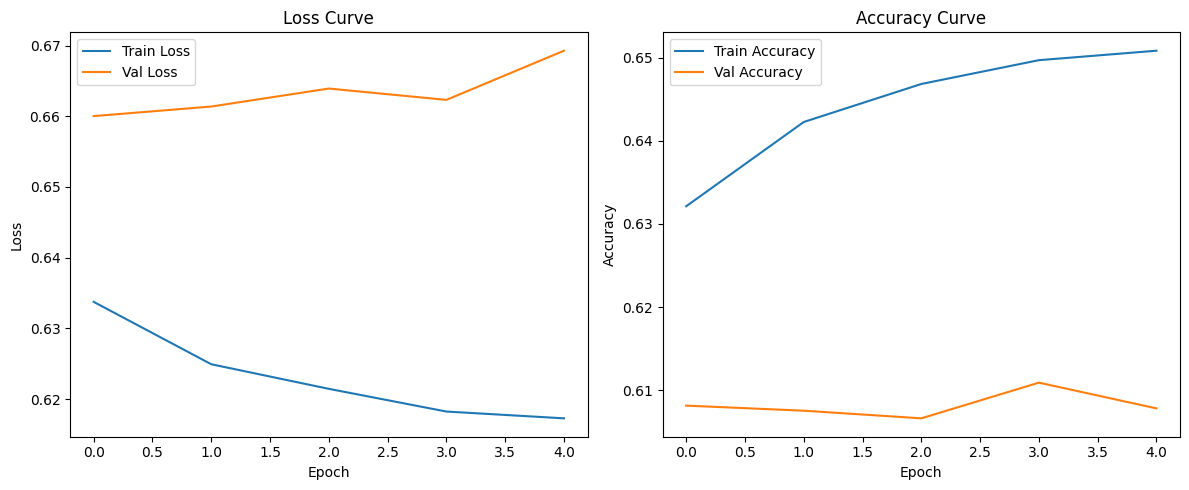


🔍 Evaluating best model on the test set...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_14764\843638373.py:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Testing: 100%|██████████| 25393/25393 [24:54<00:00, 16.99it/s]



📊 Final Test Results:
Test Loss: 0.6516 | Accuracy: 0.6301 | Precision: 0.2650 | Recall: 0.3985 | F1 Score: 0.3183
✅ Test predictions saved to: patch_predictions/10x\ResNet50_linprob_test.csv
📊 Epoch metrics saved to: patch_predictions/10x\ResNet50_linprob_epoch_metrics.csv


In [9]:
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Setup
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Only optimize the classification head (linear layer) - for linear probing
optimizer = torch.optim.Adam(model.fc.parameters(), lr=2e-5) # increased learning rate

criterion = torch.nn.CrossEntropyLoss()
device = 'cuda'
num_epochs = 5
patience = 5

# model_save_path = '/Users/Vivian/Documents/CONCH/_finetune_weights_CONCH/with_val_earlystop.pth'
# csv_save_path = "/Users/Vivian/Documents/CONCH/patch_predictions/with_val_earlystop.csv"

# Define model save path 
model_dir = "/Users/Vivian/Documents/CONCH/_finetune_weights_ResNet50/10x"
# Define CSV path for saving patch predictions
csv_dir = "patch_predictions/10x"

# check for model save path directory 
os.makedirs(model_dir, exist_ok=True)
model_save_path = os.path.join(model_dir, "linprob.pth") # change model name here
# check for csv save path directory 
os.makedirs(csv_dir, exist_ok=True)
csv_save_path = os.path.join(csv_dir, "ResNet50_linprob.csv") # change prediction csv name here


best_val_accuracy = 0
epochs_no_improve = 0

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Metrics tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Store per-epoch metrics as a list of dicts
epoch_metrics = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    correct_train, total_train = 0, 0
    all_train_labels, all_train_preds = [], []

    for images, labels, _ in tqdm.tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # without softmax (auroc)

        # probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        # _, predicted = torch.max(outputs, 1)    

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    train_precision = precision_score(all_train_labels, all_train_preds, average="binary")
    train_recall = recall_score(all_train_labels, all_train_preds, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_preds, average="binary")

    print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f} | "
        f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")


    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0
    all_val_labels, all_val_preds = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm.tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(all_val_labels, all_val_preds, average="binary")
    val_recall = recall_score(all_val_labels, all_val_preds, average="binary")
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")

    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f}")


    # Collect metrics for this epoch
    epoch_metrics.append({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Val Loss": avg_val_loss,
        "Val Accuracy": val_accuracy,
        "Val Precision": val_precision,
        "Val Recall": val_recall,
        "Val F1 Score": val_f1
    })


    # --- Early Stopping ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved with improved val accuracy: {val_accuracy:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")

# --- Append summary row ---
summary_row = {
    "Epoch": "Best Val",
    "Train Loss": "",
    "Train Accuracy": "",
    "Train Precision": "",
    "Train Recall": "",
    "Train F1 Score": "",
    "Val Loss": "",
    "Val Accuracy": best_val_accuracy,
    "Val Precision": "",
    "Val Recall": "",
    "Val F1 Score": "",
    "Test Loss": avg_test_loss,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}
epoch_metrics.append(summary_row)


metrics_df = pd.DataFrame(epoch_metrics)
metrics_csv_path = csv_save_path.replace(".csv", "_epoch_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Epoch metrics saved to: {metrics_csv_path}")

# # Save as CSV (one row)
# summary_path = csv_save_path.replace(".csv", "_metrics_summary.csv")
# pd.DataFrame([metrics]).to_csv(summary_path, index=False)
# print(f"📁 Metrics summary saved to: {summary_path}")

In [ ]:
# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")

# --- Append summary row ---
summary_row = {
    "Epoch": "Best Val",
    "Train Loss": "",
    "Train Accuracy": "",
    "Train Precision": "",
    "Train Recall": "",
    "Train F1 Score": "",
    "Val Loss": "",
    "Val Accuracy": best_val_accuracy,
    "Val Precision": "",
    "Val Recall": "",
    "Val F1 Score": "",
    "Test Loss": avg_test_loss,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}
epoch_metrics.append(summary_row)


metrics_df = pd.DataFrame(epoch_metrics)
metrics_csv_path = csv_save_path.replace(".csv", "_epoch_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Epoch metrics saved to: {metrics_csv_path}")

# # Save as CSV (one row)
# summary_path = csv_save_path.replace(".csv", "_metrics_summary.csv")
# pd.DataFrame([metrics]).to_csv(summary_path, index=False)
# print(f"📁 Metrics summary saved to: {summary_path}")

Using wandb.ai

In [ ]:
import os
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize Weights & Biases
wandb.init(project="resnet50_finetuning", name="linprob_2.5x", config={
    "epochs": 3,
    "lr": 2e-5,
    "model": "ResNet50",
    "task": "linear_probing",
    "magnification": "2.5x"
})

# Optimizer setup
optimizer = torch.optim.Adam(model.fc.parameters(), lr=wandb.config.lr)
criterion = torch.nn.CrossEntropyLoss()
device = 'cuda'
num_epochs = wandb.config.epochs
patience = 5

# Paths
model_dir = "/Users/Vivian/Documents/CONCH/_finetune_weights_ResNet50/wandb_2.5x"
csv_dir = "patch_predictions/wandb_2.5x"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

model_save_path = os.path.join(model_dir, "linprob.pth")
csv_save_path = os.path.join(csv_dir, "ResNet50_linprob.csv")

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Metrics tracking
best_val_accuracy = 0
epochs_no_improve = 0
epoch_metrics = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    correct_train, total_train = 0, 0
    all_train_labels, all_train_preds, all_train_probs = [], [], []

    for images, labels, _ in tqdm.tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_probs.extend(probs.detach().cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_precision = precision_score(all_train_labels, all_train_preds)
    train_recall = recall_score(all_train_labels, all_train_preds)
    train_f1 = f1_score(all_train_labels, all_train_preds)
    train_auroc = roc_auc_score(all_train_labels, all_train_probs)

    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {train_accuracy:.4f} | "
          f"Prec: {train_precision:.4f} | Rec: {train_recall:.4f} | F1: {train_f1:.4f} | AUROC: {train_auroc:.4f}")

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0
    all_val_labels, all_val_preds, all_val_probs = [], [], []

    with torch.no_grad():
        for images, labels, _ in tqdm.tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs, 1)

            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_precision = precision_score(all_val_labels, all_val_preds)
    val_recall = recall_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_auroc = roc_auc_score(all_val_labels, all_val_probs)

    print(f"Val Loss: {avg_val_loss:.4f} | Acc: {val_accuracy:.4f} | "
          f"Prec: {val_precision:.4f} | Rec: {val_recall:.4f} | F1: {val_f1:.4f} | AUROC: {val_auroc:.4f}")

    # Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": avg_train_loss,
        "train/accuracy": train_accuracy,
        "train/precision": train_precision,
        "train/recall": train_recall,
        "train/f1": train_f1,
        "train/auroc": train_auroc,
        "val/loss": avg_val_loss,
        "val/accuracy": val_accuracy,
        "val/precision": val_precision,
        "val/recall": val_recall,
        "val/f1": val_f1,
        "val/auroc": val_auroc,
    })

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)
        print("✅ Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered")
            break

    epoch_metrics.append({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Train AUROC": train_auroc,
        "Val Loss": avg_val_loss,
        "Val Accuracy": val_accuracy,
        "Val Precision": val_precision,
        "Val Recall": val_recall,
        "Val F1 Score": val_f1,
        "Val AUROC": val_auroc
    })

# Save epoch metrics to CSV
metrics_df = pd.DataFrame(epoch_metrics)
metrics_csv_path = csv_save_path.replace(".csv", "_epoch_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Saved metrics to: {metrics_csv_path}")


# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(probs.cpu().numpy())  # For AUROC

        # Append test predictions for CSV
        for i in range(labels.size(0)):
            test_predictions_list.append([
                file_paths[i],
                int(predicted[i].cpu()),
                int(labels[i].cpu())
            ])

avg_test_loss = total_test_loss / len(test_loader)

# Convert to NumPy arrays
y_true = np.array(all_test_labels)
y_pred = np.array([int(p > 0.5) for p in all_test_preds])  # threshold probs at 0.5
y_probs = np.array(all_test_preds)  # for AUROC

# Compute metrics
test_accuracy = (y_pred == y_true).mean()
test_precision = precision_score(y_true, y_pred, average="binary")
test_recall = recall_score(y_true, y_pred, average="binary")
test_f1 = f1_score(y_true, y_pred, average="binary")
test_auroc = roc_auc_score(y_true, y_probs)

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f} | AUROC: {test_auroc:.4f}")

wandb.log({
    "test/loss": avg_test_loss,
    "test/accuracy": test_accuracy,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/f1": test_f1,
    "test/auroc": test_auroc
})

wandb: Currently logged in as: vnguyen16 (vnguyen16-queen-s-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/13559 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 13559/13559 [13:28<00:00, 16.76it/s]


Train Loss: 0.6419 | Acc: 0.6169 | Prec: 0.6328 | Rec: 0.7408 | F1: 0.6826 | AUROC: 0.6675


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/3740 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 3740/3740 [03:47<00:00, 16.44it/s]


Val Loss: 0.6367 | Acc: 0.6322 | Prec: 0.6451 | Rec: 0.7135 | F1: 0.6776 | AUROC: 0.6796
✅ Saved best model

Epoch 2/3


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/13559 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 13559/13559 [11:54<00:00, 18.97it/s]


Train Loss: 0.6252 | Acc: 0.6360 | Prec: 0.6554 | Rec: 0.7281 | F1: 0.6899 | AUROC: 0.6942


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/3740 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 3740/3740 [03:25<00:00, 18.23it/s]

Val Loss: 0.6452 | Acc: 0.6305 | Prec: 0.6275 | Rec: 0.7826 | F1: 0.6965 | AUROC: 0.6760

Epoch 3/3


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training:   0%|          | 0/13559 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 13559/13559 [10:02<00:00, 22.49it/s]


Train Loss: 0.6191 | Acc: 0.6424 | Prec: 0.6625 | Rec: 0.7272 | F1: 0.6933 | AUROC: 0.7030


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation:   0%|          | 0/3740 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 3740/3740 [03:09<00:00, 19.73it/s]


Val Loss: 0.6433 | Acc: 0.6276 | Prec: 0.6333 | Rec: 0.7422 | F1: 0.6835 | AUROC: 0.6750
📊 Saved metrics to: patch_predictions/wandb_2.5x\ResNet50_linprob_epoch_metrics.csv

🔍 Evaluating best model on the test set...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\633093808.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Testing:   0%|          | 0/2614 [00:00<?, ?it/s]


NameError: name 'i' is not defined

In [ ]:
# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(probs.cpu().numpy())  # For AUROC

        # Append test predictions for CSV
        for i in range(labels.size(0)):
            test_predictions_list.append([
                file_paths[i],
                int(predicted[i].cpu()),
                int(labels[i].cpu())
            ])

avg_test_loss = total_test_loss / len(test_loader)

# Convert to NumPy arrays
y_true = np.array(all_test_labels)
y_pred = np.array([int(p > 0.5) for p in all_test_preds])  # threshold probs at 0.5
y_probs = np.array(all_test_preds)  # for AUROC

# Compute metrics
test_accuracy = (y_pred == y_true).mean()
test_precision = precision_score(y_true, y_pred, average="binary")
test_recall = recall_score(y_true, y_pred, average="binary")
test_f1 = f1_score(y_true, y_pred, average="binary")
test_auroc = roc_auc_score(y_true, y_probs)

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f} | AUROC: {test_auroc:.4f}")

wandb.log({
    "test/loss": avg_test_loss,
    "test/accuracy": test_accuracy,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/f1": test_f1,
    "test/auroc": test_auroc
})


🔍 Evaluating best model on the test set...


C:\Users\Vivian\AppData\Local\Temp\ipykernel_30164\968844249.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Testing: 100%|██████████| 2614/2614 [00:24<00:00, 106.73it/s]


📊 Final Test Results:
Test Loss: 0.6925 | Accuracy: 0.5798 | Precision: 0.2946 | Recall: 0.6576 | F1 Score: 0.4069 | AUROC: 0.6601


uni og patches - updated LR 1ep

In [ ]:
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Setup
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Only optimize the classification head (linear layer) - for linear probing
optimizer = torch.optim.Adam(model.fc.parameters(), lr=2e-5) # increased learning rate

criterion = torch.nn.CrossEntropyLoss()
device = 'cuda'
num_epochs = 1
patience = 5

# model_save_path = '/Users/Vivian/Documents/CONCH/_finetune_weights_CONCH/with_val_earlystop.pth'
# csv_save_path = "/Users/Vivian/Documents/CONCH/patch_predictions/with_val_earlystop.csv"

# Define model save path 
model_save_path = "/Users/Vivian/Documents/CONCH/_finetune_weights_UNI/linprob_ann_newLR_1ep.pth"
# Define CSV path for saving patch predictions
csv_save_path = "patch_predictions/annotated/UNI_ann_newLR_1ep.csv"

best_val_accuracy = 0
epochs_no_improve = 0

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Metrics tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Store per-epoch metrics as a list of dicts
epoch_metrics = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    correct_train, total_train = 0, 0
    all_train_labels, all_train_preds = [], []

    for images, labels, _ in tqdm.tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    train_precision = precision_score(all_train_labels, all_train_preds, average="binary")
    train_recall = recall_score(all_train_labels, all_train_preds, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_preds, average="binary")

    print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f} | "
        f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")


    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0
    all_val_labels, all_val_preds = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm.tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(all_val_labels, all_val_preds, average="binary")
    val_recall = recall_score(all_val_labels, all_val_preds, average="binary")
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")

    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f}")


    # Collect metrics for this epoch
    epoch_metrics.append({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Val Loss": avg_val_loss,
        "Val Accuracy": val_accuracy,
        "Val Precision": val_precision,
        "Val Recall": val_recall,
        "Val F1 Score": val_f1
    })


    # --- Early Stopping ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0

        # Ensure directory exists
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved with improved val accuracy: {val_accuracy:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")


# --- Append summary row ---
summary_row = {
    "Epoch": "Best Val",
    "Train Loss": "",
    "Train Accuracy": "",
    "Train Precision": "",
    "Train Recall": "",
    "Train F1 Score": "",
    "Val Loss": "",
    "Val Accuracy": best_val_accuracy,
    "Val Precision": "",
    "Val Recall": "",
    "Val F1 Score": "",
    "Test Loss": avg_test_loss,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}
epoch_metrics.append(summary_row)


metrics_df = pd.DataFrame(epoch_metrics)
metrics_csv_path = csv_save_path.replace(".csv", "_epoch_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Epoch metrics saved to: {metrics_csv_path}")


uni original patches (no CL) - updated LR

In [ ]:
import torch
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Setup
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Only optimize the classification head (linear layer) - for linear probing
optimizer = torch.optim.Adam(model.fc.parameters(), lr=2e-5) # increased learning rate

criterion = torch.nn.CrossEntropyLoss()
device = 'cuda'
num_epochs = 10
patience = 5

# model_save_path = '/Users/Vivian/Documents/CONCH/_finetune_weights_CONCH/with_val_earlystop.pth'
# csv_save_path = "/Users/Vivian/Documents/CONCH/patch_predictions/with_val_earlystop.csv"

# Define model save path 
model_save_path = "/Users/Vivian/Documents/CONCH/_finetune_weights_UNI/linprob_ann_newLR.pth"
# Define CSV path for saving patch predictions
csv_save_path = "patch_predictions/annotated/UNI_ann_newLR.csv"

best_val_accuracy = 0
epochs_no_improve = 0

# Mixed Precision
scaler = torch.cuda.amp.GradScaler()

# Metrics tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Store per-epoch metrics as a list of dicts
epoch_metrics = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    correct_train, total_train = 0, 0
    all_train_labels, all_train_preds = [], []

    for images, labels, _ in tqdm.tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    train_precision = precision_score(all_train_labels, all_train_preds, average="binary")
    train_recall = recall_score(all_train_labels, all_train_preds, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_preds, average="binary")

    print(f"Train Loss: {avg_train_loss:.4f} | Accuracy: {train_accuracy:.4f} | "
        f"Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1 Score: {train_f1:.4f}")


    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0
    all_val_labels, all_val_preds = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm.tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(all_val_labels, all_val_preds, average="binary")
    val_recall = recall_score(all_val_labels, all_val_preds, average="binary")
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")

    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f}")


    # Collect metrics for this epoch
    epoch_metrics.append({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Val Loss": avg_val_loss,
        "Val Accuracy": val_accuracy,
        "Val Precision": val_precision,
        "Val Recall": val_recall,
        "Val F1 Score": val_f1
    })


    # --- Early Stopping ---
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0

        # Ensure directory exists
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved with improved val accuracy: {val_accuracy:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered.")
            break

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")


# --- Append summary row ---
summary_row = {
    "Epoch": "Best Val",
    "Train Loss": "",
    "Train Accuracy": "",
    "Train Precision": "",
    "Train Recall": "",
    "Train F1 Score": "",
    "Val Loss": "",
    "Val Accuracy": best_val_accuracy,
    "Val Precision": "",
    "Val Recall": "",
    "Val F1 Score": "",
    "Test Loss": avg_test_loss,
    "Test Accuracy": test_accuracy,
    "Test Precision": test_precision,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1
}
epoch_metrics.append(summary_row)


metrics_df = pd.DataFrame(epoch_metrics)
metrics_csv_path = csv_save_path.replace(".csv", "_epoch_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"📊 Epoch metrics saved to: {metrics_csv_path}")


In [ ]:

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# --- Final Test Evaluation ---
print("\n🔍 Evaluating best model on the test set...")
model.load_state_dict(torch.load(model_save_path))
model.eval()

total_test_loss = 0
correct_test, total_test = 0, 0
all_test_labels, all_test_preds = [], []
test_predictions_list = []

with torch.no_grad():
    for images, labels, file_paths in tqdm.tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            test_predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_precision = precision_score(all_test_labels, all_test_preds, average="binary")
test_recall = recall_score(all_test_labels, all_test_preds, average="binary")
test_f1 = f1_score(all_test_labels, all_test_preds, average="binary")

print(f"\n📊 Final Test Results:\n"
      f"Test Loss: {avg_test_loss:.4f} | Accuracy: {test_accuracy:.4f} | "
      f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1 Score: {test_f1:.4f}")

# Save test predictions
test_csv_path = csv_save_path.replace(".csv", "_test.csv")
df_test = pd.DataFrame(test_predictions_list, columns=["Patch Path", "Predicted", "True Label"])
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test predictions saved to: {test_csv_path}")


UNI2 - Trying to use mixed precison to speed up training time

In [ ]:
# taking very long to train - only 14% through first epoch after 7 hours

import torch
import tqdm
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define number of epochs
num_epochs = 5

# Define model save path
model_save_path = "/Users/Vivian/Documents/CONCH/_finetune_weights_UNI2/all_slides_model1.pth"

# Define CSV path for saving patch predictions
csv_save_path = "/Users/Vivian/Documents/CONCH/patch_predictions_UNI2.csv"

# Best accuracy tracker
best_accuracy = 0

# Enable AMP for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Device setup
device = 'cuda'

# Start training loop
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    model.train()

    total_train_loss = 0
    num_train_batches = 0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_predictions = []

    # Training phase
    for batch in tqdm.tqdm(train_loader, desc="Training"):
        images, labels, img_path = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass using AMP
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track training loss
        total_train_loss += loss.item()
        num_train_batches += 1

        # Track training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    avg_train_loss = total_train_loss / num_train_batches
    train_accuracy = correct_train / total_train
    train_precision = precision_score(all_train_labels, all_train_predictions, average="binary")
    train_recall = recall_score(all_train_labels, all_train_predictions, average="binary")
    train_f1 = f1_score(all_train_labels, all_train_predictions, average="binary")

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} - Train Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        num_test_batches = 0
        correct_test = 0
        total_test = 0
        all_test_labels = []
        all_test_predictions = []
        predictions_list = []  # List to store patch-level predictions

        for batch in tqdm.tqdm(test_loader, desc="Testing"):
            images, labels, file_paths = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass using AMP
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Track test loss
            total_test_loss += loss.item()
            num_test_batches += 1

            # Track test accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

            # Store predictions for CSV
            for i in range(labels.size(0)):
                predictions_list.append([file_paths[i], predicted[i].item(), labels[i].item()])

        # Compute test classification metrics
        test_accuracy = correct_test / total_test
        test_precision = precision_score(all_test_labels, all_test_predictions, average="binary")
        test_recall = recall_score(all_test_labels, all_test_predictions, average="binary")
        test_f1 = f1_score(all_test_labels, all_test_predictions, average="binary")
        avg_test_loss = total_test_loss / num_test_batches  # Compute average test loss

        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs} - Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

        # Save model and predictions CSV only if test accuracy improves
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved with accuracy: {test_accuracy:.4f}")

            # Save predictions to CSV
            df_predictions = pd.DataFrame(predictions_list, columns=["Patch Path", "Predicted", "True Label"])
            df_predictions.to_csv(csv_save_path, index=False)
            print(f"Patch predictions saved to: {csv_save_path}")
